In [1]:
%matplotlib widget
import glob
import pandas as pd
import sys
import statistics
from datetime import datetime
from collections import defaultdict
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.transforms import Affine2D

Declare global paths and variables

In [2]:
OUTER_LOG_DIR = "/home/vagrant/mini-ndn/work/log/svs"

NUM_NODES = 20
PUB_TIMING_VALS = [1000, 5000, 10000, 15000]
RUN_NUMBER_VALS = list(range(1, 4))

LOG_PREFIXES = ["GEANT_L0", "GEANT_L5", "GEANT_L10"]
LOG_PREFIX_LABELS = ["No Loss", "5% Loss", "10% Loss"]
COLORS = ["blue", "orange", "red"]

Process all log files

In [3]:
def process_log(LOG_PREFIX):
    # Data variables
    TIMING_DATA[LOG_PREFIX] = [[] for x in PUB_TIMING_VALS]
    SYNC_INT_DATA[LOG_PREFIX] = [[] for x in PUB_TIMING_VALS]
    SUCCESS_DATA[LOG_PREFIX] = [[] for x in PUB_TIMING_VALS]
    NUM_PUBLISHED_DATA[LOG_PREFIX] = [[] for x in PUB_TIMING_VALS]

    NUM_nInInterests[LOG_PREFIX] = [[] for x in PUB_TIMING_VALS]
    NUM_nOutData[LOG_PREFIX] = [[] for x in PUB_TIMING_VALS]

    for i_t, PUB_TIMING in enumerate(PUB_TIMING_VALS):
        for RUN_NUMBER in RUN_NUMBER_VALS:
            PUBLISHING_NODES = []

            # Let log directory and files
            LOG_NAME = "{}-{}-{}".format(LOG_PREFIX, PUB_TIMING, RUN_NUMBER)
            LOG_DIR = OUTER_LOG_DIR + '/' + LOG_NAME

            print("Processing", LOG_NAME)

            PUBLISHES = {}
            SYNCS = {}
            RECIEVES = {}
            SYNC_INTS = 0

            for logfile in glob.glob(LOG_DIR + "/*.log"):
                nodename = logfile.split('/')[-1].split('.')[0]
                df = pd.read_csv(logfile, header=None, names=['t', 'pid', 'tid', 'm'], skipinitialspace = True)
                df = df.replace(' "', '', regex=True).replace('"', '', regex=True)

                for index, row in df.iterrows():
                    t = datetime.strptime(row['t'], "%Y-%m-%d %H:%M:%S.%f")
                    ti = int((t - datetime.utcfromtimestamp(0)).total_seconds() * 1000)
                    m = row['m'].split('::')

                    if 'PUBL_MSG' in m[0]:
                        PUBLISHES[m[2]] = ti
                    if 'RECV_MSG' in m[0]:
                        if m[2] not in RECIEVES:
                            RECIEVES[m[2]] = {'nodes': [], 'times': []}
                        RECIEVES[m[2]]['nodes'].append(m[1])
                        RECIEVES[m[2]]['times'].append(ti)
                    if 'SEND_SYNC_INT' in m[0]:
                        SYNC_INTS += 1

            for msg in RECIEVES:
                if msg not in PUBLISHES:
                    print(msg, 'was received and never published :)')
                    exit(1)

                pubtime = PUBLISHES[msg]
                recv_times = RECIEVES[msg]['times']

                deltas = [x - pubtime for x in recv_times]
                publisher = msg.split('/')[3]
                if publisher not in PUBLISHING_NODES:
                    PUBLISHING_NODES.append(publisher)

                TIMING_DATA[LOG_PREFIX][i_t].extend(deltas)

            SYNC_INT_DATA[LOG_PREFIX][i_t].append(SYNC_INTS / len(PUBLISHES))
            SUCCESS_DATA[LOG_PREFIX][i_t].append((len([x for k in RECIEVES for x in RECIEVES[k]['times']]) / (NUM_NODES - 1)) / len(PUBLISHES))
            NUM_PUBLISHED_DATA[LOG_PREFIX][i_t].append(len(PUBLISHES))

            nInInterests = 0
            nOutData = 0
            for startfile in glob.glob(LOG_DIR + "/report-start-*.status"):
                nodename = startfile.split('/')[-1].split('.')[0].split('-')[-1]
                endfile = startfile.replace('report-start', 'report-end')

                def read_status_file(filename):
                    status = {}
                    with open(filename, "r") as sf:
                        for line in sf.readlines():
                            if "Channels" in line:
                                break

                            if "=" in line:
                                line = line.strip()
                                v = line.split('=')
                                try:
                                    status[v[0]] = int(v[1])
                                except ValueError:
                                    status[v[0]] = v[1]
                    return status

                start = read_status_file(startfile)
                end = read_status_file(endfile)

                nInInterests += end['nInInterests'] - start['nInInterests']
                nOutData += end['nOutData'] - start['nOutData']

            NUM_nInInterests[LOG_PREFIX][i_t].append(nInInterests / len(PUBLISHES))
            NUM_nOutData[LOG_PREFIX][i_t].append(nOutData / len(PUBLISHES))

    print("Done", LOG_PREFIX)

In [4]:
TIMING_DATA = {}
SYNC_INT_DATA = {}
SUCCESS_DATA = {}
NUM_PUBLISHED_DATA = {}

NUM_nInInterests = {}
NUM_nOutData = {}

for LOG_PREFIX in LOG_PREFIXES:
    process_log(LOG_PREFIX)

Processing GEANT_L0-1000-1
Processing GEANT_L0-1000-2
Processing GEANT_L0-1000-3
Processing GEANT_L0-5000-1
Processing GEANT_L0-5000-2
Processing GEANT_L0-5000-3
Processing GEANT_L0-10000-1
Processing GEANT_L0-10000-2
Processing GEANT_L0-10000-3
Processing GEANT_L0-15000-1
Processing GEANT_L0-15000-2
Processing GEANT_L0-15000-3
Done GEANT_L0
Processing GEANT_L5-1000-1
Processing GEANT_L5-1000-2
Processing GEANT_L5-1000-3
Processing GEANT_L5-5000-1
Processing GEANT_L5-5000-2
Processing GEANT_L5-5000-3
Processing GEANT_L5-10000-1
Processing GEANT_L5-10000-2
Processing GEANT_L5-10000-3
Processing GEANT_L5-15000-1
Processing GEANT_L5-15000-2
Processing GEANT_L5-15000-3
Done GEANT_L5
Processing GEANT_L10-1000-1
Processing GEANT_L10-1000-2
Processing GEANT_L10-1000-3
Processing GEANT_L10-5000-1
Processing GEANT_L10-5000-2
Processing GEANT_L10-5000-3
Processing GEANT_L10-10000-1
Processing GEANT_L10-10000-2
Processing GEANT_L10-10000-3
Processing GEANT_L10-15000-1
Processing GEANT_L10-15000-2

In [5]:
PUB_TIMING_VALS_SEC = [x/1000 for x in PUB_TIMING_VALS]

Plot all statistics

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

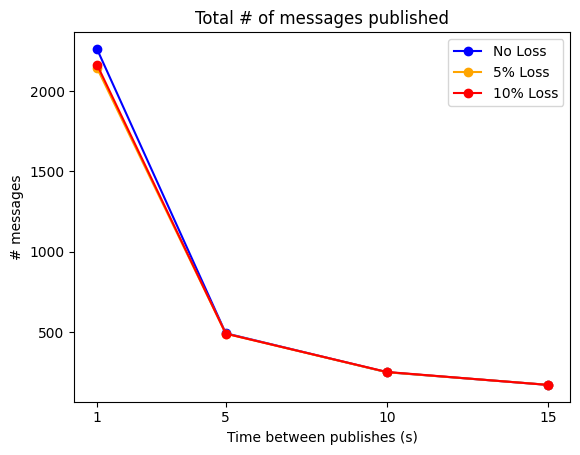

In [6]:
fig, ax = plt.subplots()
ax.set_title('Total # of messages published')
ax.set_ylabel('# messages')
ax.set_xlabel('Time between publishes (s)')
ax.set_xticks(PUB_TIMING_VALS_SEC)

for i, LOG_PREFIX in enumerate(LOG_PREFIXES):
    data = [sum(x)/len(x) for x in NUM_PUBLISHED_DATA[LOG_PREFIX]]
    ax.plot(PUB_TIMING_VALS_SEC, data, '-o', label=LOG_PREFIX_LABELS[i], color=COLORS[i])
    
ax.legend()

display(fig)
plt.close()

In [7]:
def do_plots(glob_data, ax, ninety=False):
    for i, LOG_PREFIX in enumerate(LOG_PREFIXES):
        data = glob_data[LOG_PREFIX]
        d = [np.percentile(x, 50) for x in data]
        yu = np.abs([np.percentile(x, 75) for x in data] - np.array(d))
        yl = np.abs([np.percentile(x, 25) for x in data] - np.array(d))

        trans = Affine2D().translate(-0.2+0.2 * i, 0.0) + ax.transData
        ax.errorbar(PUB_TIMING_VALS_SEC, d, yerr=[yl, yu],
                    fmt='-^', color=COLORS[i], transform=trans,
                    solid_capstyle='projecting', capsize=4, label=LOG_PREFIX_LABELS[i])

        if ninety:
            ax.plot(PUB_TIMING_VALS_SEC, [np.percentile(x, 90) for x in data], ':', 
                    color=COLORS[i], transform=trans)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

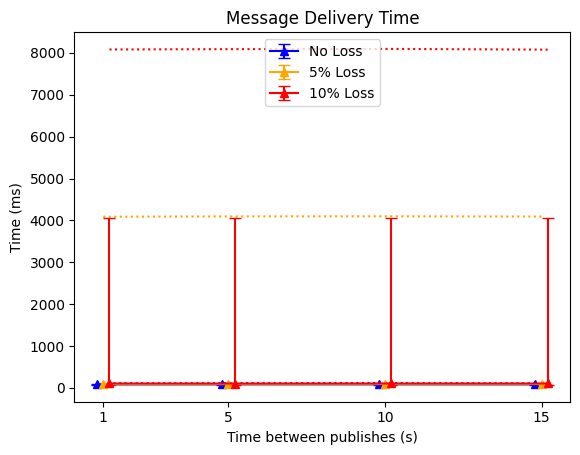

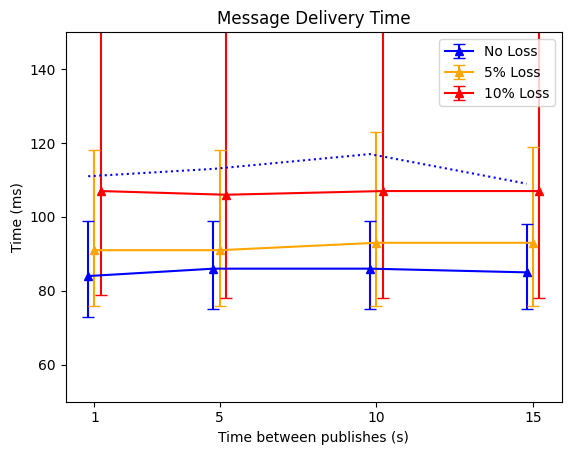

In [8]:
fig, ax = plt.subplots()
ax.set_title('Message Delivery Time')
ax.set_ylabel('Time (ms)')
ax.set_xlabel('Time between publishes (s)')
ax.set_xticks(PUB_TIMING_VALS_SEC)

do_plots(TIMING_DATA, ax, ninety=True)

ax.legend()
display(fig)
ax.set_ylim(50, 150)
display(fig)
plt.close()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

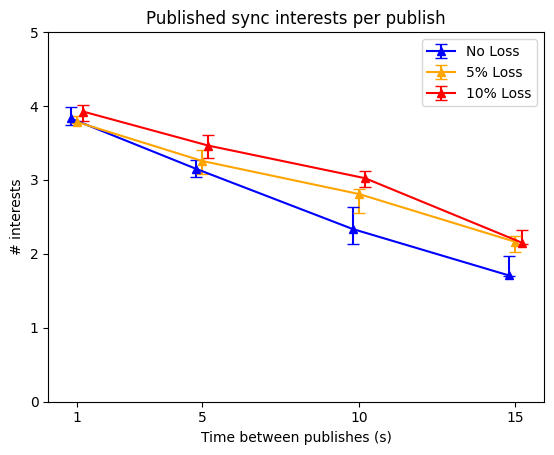

In [9]:
fig, ax = plt.subplots()
ax.set_title('Published sync interests per publish')
ax.set_ylabel('# interests')
ax.set_xlabel('Time between publishes (s)')
ax.set_xticks(PUB_TIMING_VALS_SEC)

do_plots(SYNC_INT_DATA, ax)

ax.legend()
ax.set_ylim(0, 5)
display(fig)
plt.close()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

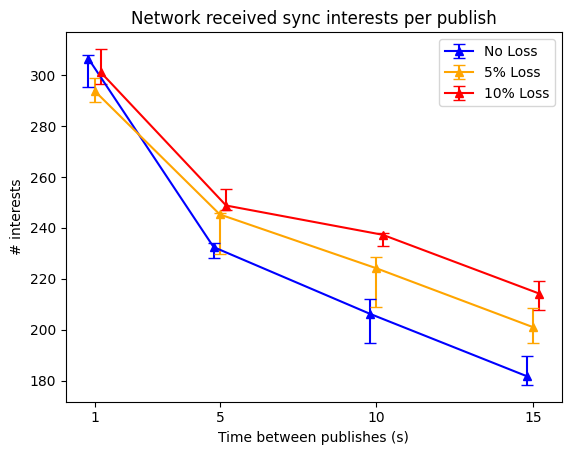

In [10]:
fig, ax = plt.subplots()
ax.set_title('Network received sync interests per publish')
ax.set_ylabel('# interests')
ax.set_xlabel('Time between publishes (s)')
ax.set_xticks(PUB_TIMING_VALS_SEC)


do_plots(NUM_nInInterests, ax)
ax.legend()
display(fig)
plt.close()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

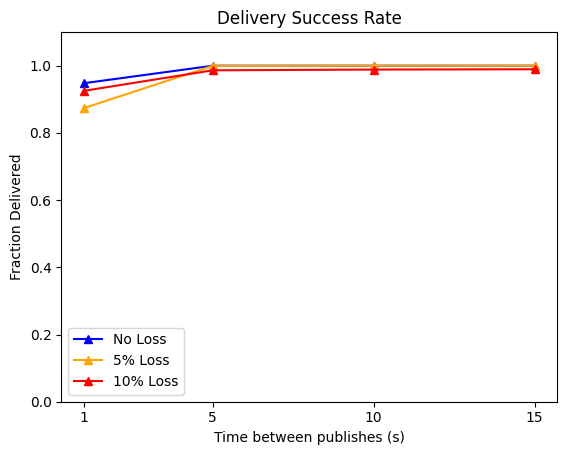

In [11]:
fig, ax = plt.subplots()
ax.set_title('Delivery Success Rate')
ax.set_ylabel('Fraction Delivered')
ax.set_xlabel('Time between publishes (s)')
ax.set_xticks(PUB_TIMING_VALS_SEC)
ax.set_ylim(0, 1.1)

for i, LOG_PREFIX in enumerate(LOG_PREFIXES):
    data = SUCCESS_DATA[LOG_PREFIX]
    ax.plot(PUB_TIMING_VALS_SEC, [np.percentile(x, 50) for x in data], '^-', 
            color=COLORS[i], label=LOG_PREFIX_LABELS[i])

ax.legend()
display(fig)
plt.close()